# 生存分析

生存分析是统计学的一个分支，专门用来分析期望的事件发生所需要的时间。生存分析回答类似的问题：某一类人群他们能否活超过多长时间？在给定的时间之后，有多大可能性去世或者发生其它事件？是否有多种原因会综合影响到生存时间？有哪些独特的环境或特征会延长或减少生存时间？

在不同领域生存分析的应用
* 在医学上可以是剩余生存时间
* 在机械设备中可以是故障发生时间预测（Reliability Analysis）
* 金融财经领域内某类事件的持续性分析（Duration Analysis）
* 社会学的历史事件分析（Event History Analysis）

## 1. 生存分析的场景

* 描述特定人群的生存时间
    * Life Tables 生命统计表
    * Kaplan-Meier 曲线
    * Survive Function 生存函数
    * Hazard Function 危害函数
* 对比不同人群的生存时间
    * Log Rank Test
* 描述某种特征变量（类别或者数值）对生存的影响
    * Cox proportional hazard regression 比例回归模型
    * Parametric survival models 
    * Survival trees
    * Survival Random Forests



## 2. 案例分析

### 2.1. 急性白血病人生存分析
目标是确定：是否需要继续对患者使用标准的化疗疗程？

数据集：R package ’survival’, data set ‘aml’, from Miller, 1997

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

#参数初始化
inputfile = '../data/leukemia.csv' #销量及其他属性数据
data = pd.read_csv(inputfile, index_col = 'observation') #读取数据

data.head()

,time,status,x
observation,,,
1,9,1,Maintained
2,13,1,Maintained
3,13,0,Maintained
4,18,1,Maintained
5,23,1,Maintained


上表即为aml的样例数据
* Observation：即为病人的ID
* Time：生存时间和审查时间，单位为周week
* Status：白血病复发事件，0代表没有，1代表复发了
* X（Treatment group）后续的治疗：是否持续性的采用了化疗

#### 2.1.1 生存函数与KM曲线分析
Survival Function S(t) 是患者的生存时间超过某个时间t的概率。理论上S(t)是一个连续函数，但是通常的KM曲线如下：


生存概率：
          KM_estimate
timeline             
0.0          1.000000
5.0          0.913043
8.0          0.826087
9.0          0.782609
12.0         0.739130
13.0         0.695652
16.0         0.695652
18.0         0.645963
23.0         0.546584
27.0         0.496894
28.0         0.496894
30.0         0.441684
31.0         0.386473
33.0         0.331263
34.0         0.276052
43.0         0.220842
45.0         0.165631
48.0         0.082816
161.0        0.082816


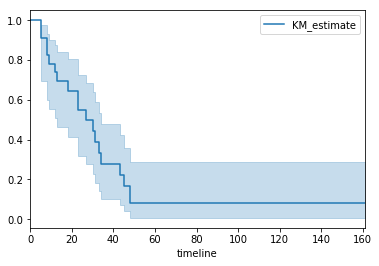

In [98]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(data['time'], event_observed=data['status'])
print('生存概率：')
print(kmf.survival_function_)
kmf.median_
kmf.plot()

X轴时间，Y轴是生存概率，越往后存活概率越低。实线是白血病复发的事件，tick mark是指censored的未复发事件。因为只有一个人存活超过161周，所以161周内未复发概率为0.1，同时在161周标记了tick mark。

#### 2.1.2 生命统计表
生存统计表总结了整个数据集，根据在每个时间点上，观察到的事件数量，将会展示：
* Time：给出事件发生的时间点
* n.risk：在时间点t之前，白血病复发事件还没有发生的患者数量，包含最终censored没有发生事件的患者数量
* n.event：在时间点t，白血病复发的患者数量
* survival：在时间点t的生存比例
* std.err：在时间点t，存活比例的标准差
* lower 95% CI：95%置信度的最低生存比例
* upper 95% CI：95%置信度的最高生存比例

In [93]:
weeks = sorted(data.time.unique())
total_observation = data.time.count() # 23 observed patients

def get_records_by_time(week):
    return data.loc[lambda df: df.time <= week]


import math

for week in weeks:
    records = get_records_by_time(week)
    death_num = records[lambda df: df.status == 1].time.count()
    death = np.ones(death_num)
    survival = np.ones(total_observation - death_num)
    survival_list = np.concatenate([death, survival])
    survival_ratio = (total_observation - death_num) / total_observation
    diff = survival_list - survival_ratio
    std_err = math.sqrt((diff * diff).sum() / 23)
    print(week, std_err, survival_list.std(), survival_list.mean(), survival_ratio, survival_list)

5 0.0869565217391305 0.0 1.0 0.913043478261 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
8 0.1739130434782608 0.0 1.0 0.826086956522 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
9 0.21739130434782605 0.0 1.0 0.782608695652 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
12 0.26086956521739135 0.0 1.0 0.739130434783 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
13 0.30434782608695654 0.0 1.0 0.695652173913 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
16 0.30434782608695654 0.0 1.0 0.695652173913 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
18 0.3478260869565216 0.0 1.0 0.652173913043 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.]
23 0.43478260869565

In [15]:
from lifelines.utils import survival_events_from_table, survival_table_from_events

df = pd.read_csv('../data/survival_table.csv', usecols = ['observed_deaths', 'censored'])

T, E = survival_events_from_table(df, observed_deaths_col='observed_deaths', censored_col='censored')

print(T) # array([0,0,0,0,0,0,0,1,...])
print(E) # array([1,1,1,1,1,1,1,0,...])


[ 0.  0.  0.  0.  0.  0.  0.  1.  1.  2.  2.  3.  3.  3.  4.  4.  4.  4.
  4.  4.  4.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  1.
  1.  0.  0.]
